In [7]:
#!/usr/bin/env python3
import time
import requests
import pandas as pd
from datetime import datetime, timezone
from requests.exceptions import HTTPError

# ─── CONFIG ─────────────────────────────────────────────────────────────────────
COINS = {
    "Bitcoin":      "bitcoin",
    "Ethereum":     "ethereum",
    "Solana":       "solana",
    "Cardano":      "cardano",
    "Ripple":       "ripple",
    "Dogecoin":     "dogecoin",
    "Polkadot":     "polkadot",
    "Chainlink":    "chainlink",
    "Litecoin":     "litecoin",
    "Binance Coin": "binance-coin"
}

OUT_FP = (
    "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/"
    "crypto_sentiment_project/data/News Data Crypto /historical_prices.csv"
)

MAX_RETRIES = 5
INITIAL_BACKOFF = 1  # seconds

# ─── SESSION ───────────────────────────────────────────────────────────────────
session = requests.Session()
session.headers.update({"User-Agent": "Mozilla/5.0"})

# ─── FETCH FUNCTION ─────────────────────────────────────────────────────────────
def fetch_with_backoff(url, params):
    backoff = INITIAL_BACKOFF
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            resp = session.get(url, params=params, timeout=10)
            resp.raise_for_status()
            return resp.json()
        except HTTPError as e:
            status = e.response.status_code
            if status == 429:
                print(f"⚠️ Rate-limited (429). Backing off {backoff}s (attempt {attempt}/{MAX_RETRIES})")
                time.sleep(backoff)
                backoff *= 2
            else:
                print(f"❌ HTTP {status} on {url}: {e}")
                break
        except Exception as e:
            print(f"❌ Error on {url}: {e} (attempt {attempt}/{MAX_RETRIES})")
            time.sleep(backoff)
            backoff *= 2
    return None

# ─── MAIN ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    all_rows = []

    for name, slug in COINS.items():
        print(f"🔍 Fetching 90-day history for {name}")
        url = f"https://api.coingecko.com/api/v3/coins/{slug}/market_chart"
        params = {"vs_currency": "usd", "days": 90, "interval": "daily"}
        data = fetch_with_backoff(url, params)
        if not data or "prices" not in data:
            print(f"⚠️ Skipping {name} due to fetch failures")
            continue

        prices  = data["prices"]
        caps    = data.get("market_caps", [])
        vols    = data.get("total_volumes", [])

        for i, (ts, price) in enumerate(prices):
            date = datetime.fromtimestamp(ts / 1000, tz=timezone.utc).date()
            cap  = caps[i][1]    if i < len(caps)    else None
            vol  = vols[i][1]    if i < len(vols)    else None
            all_rows.append({
                "crypto_name":    name,
                "date":           date,
                "price_usd":      price,
                "market_cap_usd": cap,
                "volume_24h_usd": vol
            })

        # polite pause
        time.sleep(1)

    # Assemble DataFrame
    df = pd.DataFrame(all_rows)
    df.sort_values(["crypto_name", "date"], inplace=True)
    df["change_24h"] = df.groupby("crypto_name")["price_usd"].pct_change() * 100

    # Save
    df.to_csv(OUT_FP, index=False)
    print(f"\n✅ Wrote {len(df)} rows to:\n   {OUT_FP}")


🔍 Fetching 90-day history for Bitcoin
⚠️ Rate-limited (429). Backing off 1s (attempt 1/5)
⚠️ Rate-limited (429). Backing off 2s (attempt 2/5)
⚠️ Rate-limited (429). Backing off 4s (attempt 3/5)
🔍 Fetching 90-day history for Ethereum
🔍 Fetching 90-day history for Solana
🔍 Fetching 90-day history for Cardano
🔍 Fetching 90-day history for Ripple
⚠️ Rate-limited (429). Backing off 1s (attempt 1/5)
⚠️ Rate-limited (429). Backing off 2s (attempt 2/5)
⚠️ Rate-limited (429). Backing off 4s (attempt 3/5)
⚠️ Rate-limited (429). Backing off 8s (attempt 4/5)
⚠️ Rate-limited (429). Backing off 16s (attempt 5/5)
⚠️ Skipping Ripple due to fetch failures
🔍 Fetching 90-day history for Dogecoin
⚠️ Rate-limited (429). Backing off 1s (attempt 1/5)
⚠️ Rate-limited (429). Backing off 2s (attempt 2/5)
⚠️ Rate-limited (429). Backing off 4s (attempt 3/5)
⚠️ Rate-limited (429). Backing off 8s (attempt 4/5)
⚠️ Rate-limited (429). Backing off 16s (attempt 5/5)
⚠️ Skipping Dogecoin due to fetch failures
🔍 Fetching

In [8]:
#!/usr/bin/env python3
import pandas as pd

# ─── 1) File paths (exactly as you have them) ─────────────────────────────────
reddit_fp      = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /reddit_crypto_bulk_tagged.csv'
cointele_fp    = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /cointelegraph_bitcoin_scroll_fixed.xlsx'
cryptoslate_fp = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /cryptoslate_articles_wpapi.xlsx'
hist_fp        = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /historical_prices.csv'
out_fp         = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /merged_daily.csv'

# ─── 2) Load & normalize news dates ─────────────────────────────────────────────
reddit      = pd.read_csv(reddit_fp)
reddit['date'] = pd.to_datetime(reddit['created_utc']).dt.date
reddit.rename(columns={'detected_coins':'crypto_name'}, inplace=True)

cointele    = pd.read_excel(cointele_fp)
cointele['date'] = pd.to_datetime(cointele['scraped_at']).dt.date

cryptoslate = pd.read_excel(cryptoslate_fp)
cryptoslate['date'] = pd.to_datetime(cryptoslate['date']).dt.date

# ─── 3) Build per-coin, per-day news counts ────────────────────────────────────
all_news = pd.concat([
    reddit[['crypto_name','date']],
    cointele[['crypto_name','date']],
    cryptoslate[['crypto_name','date']]
], ignore_index=True)

news_daily = (
    all_news
    .groupby(['crypto_name','date'])
    .size()
    .reset_index(name='news_count')
)

# ─── 4) Load historical prices ─────────────────────────────────────────────────
prices_daily = pd.read_csv(hist_fp, parse_dates=['date'])
prices_daily['date'] = prices_daily['date'].dt.date

# ─── 5) Merge & fill missing days with zero news ───────────────────────────────
merged = prices_daily.merge(
    news_daily,
    on=['crypto_name','date'],
    how='left'
).fillna({'news_count': 0})

# ─── 6) Save your merged daily dataset ─────────────────────────────────────────
merged.to_csv(out_fp, index=False)
print("✅ Created merged_daily.csv with columns:", merged.columns.tolist())


✅ Created merged_daily.csv with columns: ['crypto_name', 'date', 'price_usd', 'market_cap_usd', 'volume_24h_usd', 'change_24h', 'news_count']


In [9]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ─── 1) File paths ─────────────────────────────────────────────────────────────────
reddit_fp      = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /reddit_crypto_bulk_tagged.csv'
cointele_fp    = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /cointelegraph_bitcoin_scroll_fixed.xlsx'
cryptoslate_fp = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /cryptoslate_articles_wpapi.xlsx'
snapshot_fp    = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /crypto_prices.csv'
output_fp      = '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /crypto_snapshot_with_sentiment.csv'

# ─── 2) Load your one-day price snapshot ─────────────────────────────────────────
snapshot = pd.read_csv(snapshot_fp)

# ─── 3) Load & normalize news DataFrames ─────────────────────────────────────────
reddit      = pd.read_csv(reddit_fp)
reddit['date']     = pd.to_datetime(reddit['created_utc']).dt.date
reddit.rename(columns={'detected_coins':'crypto_name','title':'headline'}, inplace=True)

cointele    = pd.read_excel(cointele_fp)
cointele['date']   = pd.to_datetime(cointele['scraped_at']).dt.date
# cointele already has 'headline'

cryptoslate = pd.read_excel(cryptoslate_fp)
cryptoslate['date'] = pd.to_datetime(cryptoslate['date']).dt.date
cryptoslate.rename(columns={'title':'headline'}, inplace=True)

# ─── 4) Combine all headlines for that single date ───────────────────────────────
all_news = pd.concat([
    reddit[['crypto_name','date','headline']],
    cointele[['crypto_name','date','headline']],
    cryptoslate[['crypto_name','date','headline']]
], ignore_index=True)

# Optional: filter to the date of your snapshot if it's present in 'snapshot'
# e.g. snapshot_date = pd.to_datetime('2025-04-30').date()
# all_news = all_news[all_news['date'] == snapshot_date]

# ─── 5) Compute sentiment for each headline ──────────────────────────────────────
sia = SentimentIntensityAnalyzer()

def analyze(text):
    scores = sia.polarity_scores(text)
    comp = scores['compound']
    if comp >=  0.05: label =  1
    elif comp <= -0.05: label = -1
    else:               label =  0
    return pd.Series({'compound': comp, 'label': label})

sent = all_news['headline'].apply(analyze)
all_news = pd.concat([all_news, sent], axis=1)

# ─── 6) Aggregate per coin (one row per crypto) ────────────────────────────────
agg = all_news.groupby('crypto_name').agg(
    news_count   = ('headline','size'),
    pct_positive = ('label', lambda x: (x==1).mean()),
    pct_negative = ('label', lambda x: (x==-1).mean()),
    avg_compound = ('compound','mean')
).reset_index()

# ─── 7) Merge sentiment features back into your price snapshot ─────────────────
result = snapshot.merge(agg, on='crypto_name', how='left').fillna({
    'news_count':   0,
    'pct_positive': 0.0,
    'pct_negative': 0.0,
    'avg_compound': 0.0
})

# ─── 8) Save enriched snapshot ─────────────────────────────────────────────────
result.to_csv(output_fp, index=False)
print("✅ Saved snapshot with sentiment to:", output_fp)
print(result.head())


✅ Saved snapshot with sentiment to: /Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /crypto_snapshot_with_sentiment.csv
  crypto_name     price_usd  change_24h  market_cap_usd  volume_24h_usd  \
0     Bitcoin  94947.000000    0.675876    1.885621e+12    2.380231e+10   
1    Ethereum   1804.210000    0.529687    2.177299e+11    1.372255e+10   
2      Solana    147.130000    0.293568    7.614491e+10    3.184165e+09   
3     Cardano      0.699095   -0.258978    2.520022e+10    8.072727e+08   
4      Ripple      2.250000   -0.656032    1.318042e+11    2.446585e+09   

   news_count  pct_positive  pct_negative  avg_compound  
0         369      0.249322      0.273713     -0.004887  
1          26      0.461538      0.115385      0.133785  
2           9      0.555556      0.333333      0.041511  
3           2      0.500000      0.500000     -0.215150  
4          12      0.166667      0.083333      0.039992  


In [10]:
import pandas as pd
import numpy as np

from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics         import accuracy_score, classification_report

# 1) Load the one-day snapshot with sentiment
df = pd.read_csv(
    '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /crypto_snapshot_with_sentiment.csv'
)

# 2) Define features and target
features = [
    'news_count',
    'pct_positive',
    'pct_negative',
    'avg_compound',
    'price_usd',
    'market_cap_usd',
    'volume_24h_usd'
]
df['label'] = (df['change_24h'] > 0).astype(int)   # 1 if price went up, else 0
X = df[features]
y = df['label']

# 3) Leave-One-Out CV for two models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest':       RandomForestClassifier(n_estimators=100, random_state=0)
}

loo = LeaveOneOut()
results = []

for name, mdl in models.items():
    preds, trues = [], []
    for train_ix, test_ix in loo.split(X):
        mdl.fit(X.iloc[train_ix], y.iloc[train_ix])
        preds.append(mdl.predict(X.iloc[test_ix])[0])
        trues.append(y.iloc[test_ix].values[0])
    acc = accuracy_score(trues, preds)
    print(f"\n{name} LOOCV Accuracy: {acc:.2f}")
    print(classification_report(trues, preds, target_names=['Down','Up']))
    results.append((name, acc))

# 4) Fit on full data and get probabilities
for name, mdl in models.items():
    mdl.fit(X, y)
    df[f"{name}_prob_up"] = mdl.predict_proba(X)[:,1]

# 5) Show final table
out = df[[
    'crypto_name','price_usd','change_24h',
    'news_count','pct_positive','pct_negative','avg_compound',
    'LogisticRegression_prob_up', 'RandomForest_prob_up'
]]
print("\nPredicted probabilities of price ↑ tomorrow:\n", out)



LogisticRegression LOOCV Accuracy: 0.20
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00         7
          Up       0.22      0.67      0.33         3

    accuracy                           0.20        10
   macro avg       0.11      0.33      0.17        10
weighted avg       0.07      0.20      0.10        10


RandomForest LOOCV Accuracy: 0.90
              precision    recall  f1-score   support

        Down       0.88      1.00      0.93         7
          Up       1.00      0.67      0.80         3

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87        10
weighted avg       0.91      0.90      0.89        10


Predicted probabilities of price ↑ tomorrow:
     crypto_name     price_usd  change_24h  news_count  pct_positive  \
0       Bitcoin  94947.000000    0.675876         369      0.249322   
1      Ethereum   1804.210000    0.529687          26      0.461538   
2        S

/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/3828237178.py:32: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_true.append(int(y.iloc[te]))
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/3828237178.py:32: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_true.append(int(y.iloc[te]))
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/3828237178.py:32: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_true.append(int(y.iloc[te]))
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/3828237178.py:32: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_true.appe


Model Comparison Metrics:
                     accuracy  f1_score   roc_auc
model                                           
LogisticRegression       0.2  0.333333  0.333333
RandomForest             0.9  0.800000  0.761905


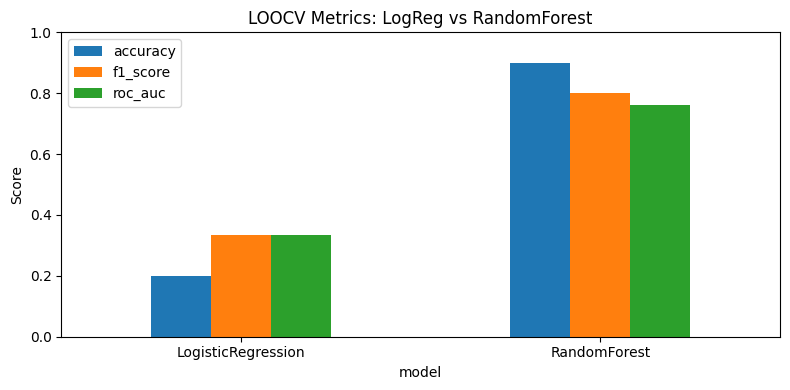

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics         import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# 1) Load snapshot with features & label
df = pd.read_csv(
    '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /crypto_snapshot_with_sentiment.csv'
)
df['label'] = (df['change_24h'] > 0).astype(int)
features = ['news_count','pct_positive','pct_negative','avg_compound',
            'price_usd','market_cap_usd','volume_24h_usd']
X = df[features]
y = df['label']

# 2) Define models and LOOCV
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest':       RandomForestClassifier(n_estimators=100, random_state=0)
}
loo = LeaveOneOut()

# 3) Collect metrics
rows = []
for name, mdl in models.items():
    y_true, y_pred, y_score = [], [], []
    for tr, te in loo.split(X):
        mdl.fit(X.iloc[tr], y.iloc[tr])
        y_true.append(int(y.iloc[te]))
        y_pred.append(int(mdl.predict(X.iloc[te])[0]))
        y_score.append(float(mdl.predict_proba(X.iloc[te])[:,1][0]))
    rows.append({
        'model':   name,
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'roc_auc':  roc_auc_score(y_true, y_score)
    })

metrics_df = pd.DataFrame(rows).set_index('model')
print("\nModel Comparison Metrics:\n", metrics_df)

# 4) Plot bar chart
metrics_df.plot.bar(
    figsize=(8,4),
    title="LOOCV Metrics: LogReg vs RandomForest",
    ylim=(0,1)
)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Bitcoin SARIMA RMSE: 11450.28


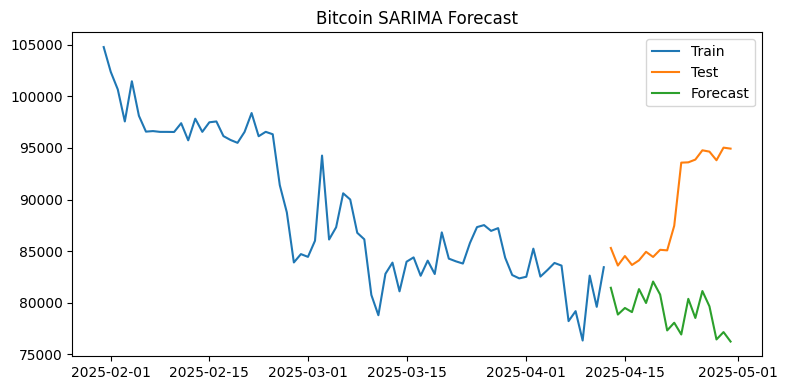

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# 1) Load merged_daily
df = pd.read_csv(
    '/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /merged_daily.csv',
    parse_dates=['date']
)

# 2) Drop duplicate (date, crypto_name) by keeping the last occurrence
df = df.sort_values(['date','crypto_name']).drop_duplicates(subset=['date','crypto_name'], keep='last')

# 3) Pivot to time-series
pv = df.pivot(index='date', columns='crypto_name', values='price_usd')

# 4) Reindex to full daily calendar and forward-fill
pv = pv.asfreq('D').ffill()

# 5) Select one coin, e.g. Bitcoin
btc = pv['Bitcoin']

# 6) Train/test split
cut = int(len(btc)*0.8)
train, test = btc.iloc[:cut], btc.iloc[cut:]

# 7) Fit SARIMA
model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

# 8) Forecast & evaluate
fcst = res.forecast(steps=len(test))
rmse = np.sqrt(mean_squared_error(test, fcst))
print(f"Bitcoin SARIMA RMSE: {rmse:.2f}")

# 9) Plot
plt.figure(figsize=(8,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index,  test,  label='Test')
plt.plot(test.index,  fcst,  label='Forecast')
plt.legend()
plt.title("Bitcoin SARIMA Forecast")
plt.tight_layout()
plt.show()


In [20]:
pip install torch torchvision torchaudio pandas matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 8.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 6.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0

[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Epoch 01 → Train MSE 0.2732, Val MSE 0.3686
Epoch 02 → Train MSE 0.2379, Val MSE 0.3270
Epoch 03 → Train MSE 0.2066, Val MSE 0.2863
Epoch 04 → Train MSE 0.1751, Val MSE 0.2452
Epoch 05 → Train MSE 0.1439, Val MSE 0.2020
Epoch 06 → Train MSE 0.1097, Val MSE 0.1561
Epoch 07 → Train MSE 0.0803, Val MSE 0.1067
Epoch 08 → Train MSE 0.0461, Val MSE 0.0586
Epoch 09 → Train MSE 0.0245, Val MSE 0.0234
Epoch 10 → Train MSE 0.0288, Val MSE 0.0154
Epoch 11 → Train MSE 0.0319, Val MSE 0.0194
Epoch 12 → Train MSE 0.0246, Val MSE 0.0308
Epoch 13 → Train MSE 0.0219, Val MSE 0.0387
Epoch 14 → Train MSE 0.0228, Val MSE 0.0406
Epoch 15 → Train MSE 0.0221, Val MSE 0.0369
Epoch 16 → Train MSE 0.0204, Val MSE 0.0310
Epoch 17 → Train MSE 0.0194, Val MSE 0.0255
Epoch 18 → Train MSE 0.0194, Val MSE 0.0231
Epoch 19 → Train MSE 0.0190, Val MSE 0.0250
Epoch 20 → Train MSE 0.0178, Val MSE 0.0278
Epoch 21 → Train MSE 0.0172, Val MSE 0.0306
Epoch 22 → Train MSE 0.0168, Val MSE 0.0312
Epoch 23 → Train MSE 0.0161, Val

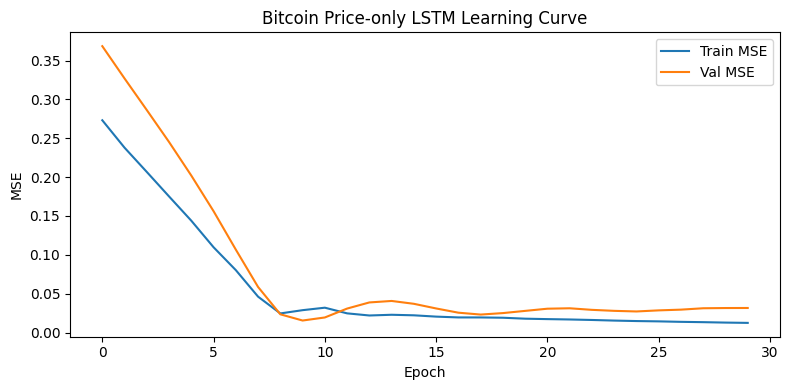


Bitcoin Univariate LSTM Test RMSE: 5054.80 USD


In [25]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ─── 1) Load your merged_daily.csv (price history) ─────────────────────────────
fp = (
    "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/"
    "crypto_sentiment_project/data/News Data Crypto /merged_daily.csv"
)
df = pd.read_csv(fp, parse_dates=["date"])
df.sort_values(["crypto_name","date"], inplace=True)

# ─── 2) Pick one coin, e.g. Bitcoin ────────────────────────────────────────────
coin = "Bitcoin"
series = df[df.crypto_name==coin].set_index("date")["price_usd"].ffill().values

# ─── 3) Scale the series ───────────────────────────────────────────────────────
scaler = MinMaxScaler()
series_s = scaler.fit_transform(series.reshape(-1,1)).flatten()

# ─── 4) Build sliding windows ───────────────────────────────────────────────────
window = 14
X, y = [], []
for i in range(len(series_s)-window):
    X.append(series_s[i:i+window])
    y.append(series_s[i+window])
X = np.array(X, dtype=np.float32)[:, :, None]  # shape (samples, window, 1)
y = np.array(y, dtype=np.float32)

# ─── 5) Train/test split (80/20) ───────────────────────────────────────────────
split = int(len(X)*0.8)
X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]

# ─── 6) DataLoaders ────────────────────────────────────────────────────────────
batch_size = 16
train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
test_ds  = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

# ─── 7) Define a univariate LSTM ───────────────────────────────────────────────
class UniLSTM(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UniLSTM().to(device)

# ─── 8) Training setup ─────────────────────────────────────────────────────────
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ─── 9) Train & validate ──────────────────────────────────────────────────────
epochs = 30
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    # train
    model.train()
    total_train = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append(total_train / len(train_loader.dataset))
    # validate
    model.eval()
    total_val = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            pred = model(xb)
            total_val += criterion(pred, yb).item() * xb.size(0)
    val_losses.append(total_val / len(test_loader.dataset))
    print(f"Epoch {epoch:02d} → Train MSE {train_losses[-1]:.4f}, Val MSE {val_losses[-1]:.4f}")

# ─── 10) Plot loss curves ──────────────────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.title(f"{coin} Price-only LSTM Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

# ─── 11) Compute test RMSE in USD ──────────────────────────────────────────────
model.eval()
with torch.no_grad():
    X_te_t = torch.from_numpy(X_te).to(device)
    y_pred_s = model(X_te_t).cpu().numpy().flatten()
rmse_s = np.sqrt(mean_squared_error(y_te, y_pred_s))
# invert scaling
y_te_usd   = scaler.inverse_transform(y_te.reshape(-1,1)).flatten()
y_pred_usd = scaler.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
print(f"\n{coin} Univariate LSTM Test RMSE: {np.sqrt(mean_squared_error(y_te_usd, y_pred_usd)):.2f} USD")


In [26]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ─── CONFIG ─────────────────────────────────────────────────────────────────────
MERGED_FP = (
  "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/"
  "crypto_sentiment_project/data/News Data Crypto /merged_daily.csv"
)
COINS = None  # will be inferred from the data
WINDOW = 14
BATCH  = 16
EPOCHS = 20
LR     = 1e-3

# ─── MODEL DEFINITION ───────────────────────────────────────────────────────────
class UniLSTM(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ─── UTILS ──────────────────────────────────────────────────────────────────────
def make_dataset(series, window):
    """Given a 1D numpy array, return (X, y) sliding-window arrays."""
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    X = np.array(X, dtype=np.float32)[:, :, None]  # shape (n, window, 1)
    y = np.array(y, dtype=np.float32)
    return X, y

# ─── MAIN ───────────────────────────────────────────────────────────────────────
df = pd.read_csv(MERGED_FP, parse_dates=["date"])
df.sort_values(["crypto_name","date"], inplace=True)
COINS = df.crypto_name.unique()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for coin in COINS:
    print(f"\n=== Training LSTM for {coin} ===")
    # 1) Extract and ffill price series
    series = df[df.crypto_name==coin].set_index("date")["price_usd"].ffill().values
    if len(series) < WINDOW*2:
        print(f"⚠️  Not enough data for {coin}, skipping.")
        continue

    # 2) Scale & make windows
    scaler = MinMaxScaler()
    series_s = scaler.fit_transform(series.reshape(-1,1)).flatten()
    X, y = make_dataset(series_s, WINDOW)

    # 3) Train/test split
    split = int(len(X)*0.8)
    X_tr, X_te = X[:split], X[split:]
    y_tr, y_te = y[:split], y[split:]

    # 4) DataLoaders
    train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
    test_ds  = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te))
    tr_lo    = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
    te_lo    = DataLoader(test_ds,  batch_size=BATCH)

    # 5) Model, loss, optimizer
    model = UniLSTM().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    # 6) Train
    for epoch in range(1, EPOCHS+1):
        model.train()
        total = 0
        for xb, yb in tr_lo:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total += loss.item() * xb.size(0)
        # you can print per-epoch if desired:
        # print(f"Epoch {epoch:02d} Train MSE: {total/len(tr_lo.dataset):.4f}")

    # 7) Evaluate
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in te_lo:
            xb = xb.to(device)
            out = model(xb).cpu().numpy().flatten()
            preds.extend(out.tolist())
            trues.extend(yb.numpy().tolist())

    # 8) Compute RMSE in USD
    y_pred_usd = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
    y_te_usd   = scaler.inverse_transform(np.array(trues).reshape(-1,1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_te_usd, y_pred_usd))
    print(f"{coin} LSTM RMSE: {rmse:.2f} USD")

    results.append({"crypto_name": coin, "lstm_rmse_usd": rmse})

# ─── SUMMARIZE ──────────────────────────────────────────────────────────────────
res_df = pd.DataFrame(results).set_index("crypto_name")
print("\nAll coins LSTM RMSEs:\n", res_df)
res_df.to_csv("lstm_all_coins_rmse.csv")



=== Training LSTM for Bitcoin ===
Bitcoin LSTM RMSE: 4524.94 USD

=== Training LSTM for Cardano ===
Cardano LSTM RMSE: 0.06 USD

=== Training LSTM for Chainlink ===
Chainlink LSTM RMSE: 0.94 USD

=== Training LSTM for Ethereum ===
Ethereum LSTM RMSE: 199.72 USD

=== Training LSTM for Litecoin ===
Litecoin LSTM RMSE: 5.83 USD

=== Training LSTM for Polkadot ===
Polkadot LSTM RMSE: 0.31 USD

=== Training LSTM for Solana ===
Solana LSTM RMSE: 9.42 USD

All coins LSTM RMSEs:
              lstm_rmse_usd
crypto_name               
Bitcoin        4524.941719
Cardano           0.062875
Chainlink         0.938700
Ethereum        199.718764
Litecoin          5.829163
Polkadot          0.305110
Solana            9.416768


✅ Strategy returns chart saved to /Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /strategy_returns.png

Final cumulative returns:
SARIMA        0.000000
LSTM          0.121488
Buy & Hold    0.133711
Name: 2025-04-30 00:00:00, dtype: float64


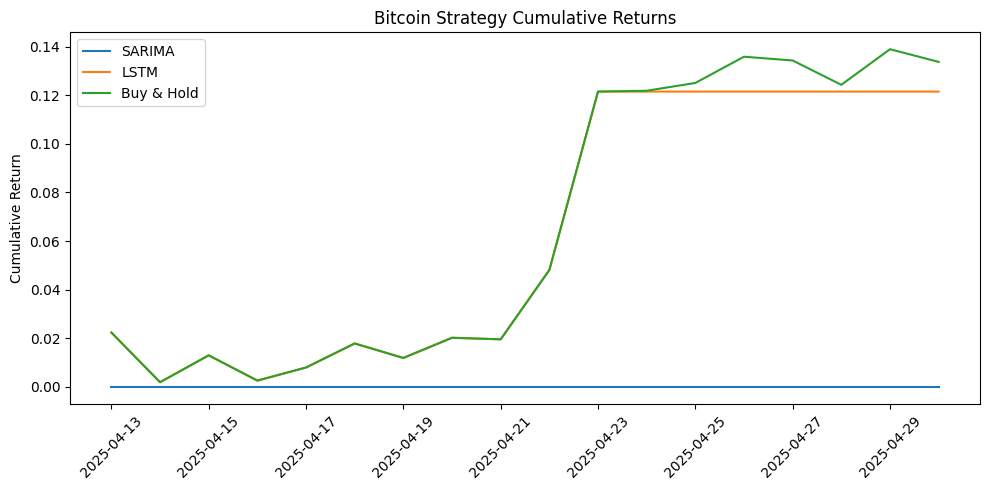

In [28]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# ─── CONFIG ─────────────────────────────────────────────────────────────────────
MERGED_FP = (
    "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/"
    "crypto_sentiment_project/data/News Data Crypto /merged_daily.csv"
)
OUT_FP = (
    "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/"
    "crypto_sentiment_project/data/News Data Crypto /strategy_returns.png"
)
WINDOW = 14
BATCH  = 16
EPOCHS = 10
LR     = 1e-3

# ─── 1) Load and dedupe ─────────────────────────────────────────────────────────
df = pd.read_csv(MERGED_FP, parse_dates=["date"])
# keep one price_usd per (date,crypto_name) by averaging duplicates
df_unique = (
    df.groupby(["date","crypto_name"], as_index=False)
      .agg({"price_usd":"mean"})
)

# ─── 2) Pivot to wide form ──────────────────────────────────────────────────────
pv = df_unique.pivot(index="date", columns="crypto_name", values="price_usd")
pv = pv.asfreq("D").ffill()

# ─── 3) Prepare Bitcoin series ─────────────────────────────────────────────────
btc = pv["Bitcoin"]
cut = int(len(btc)*0.8)
train, test = btc.iloc[:cut], btc.iloc[cut:]
dates_test  = test.index

# ─── 4) SARIMA forecast ────────────────────────────────────────────────────────
sarima = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)
fcst_sarima = sarima.forecast(steps=len(test))
fcst_sarima.index = dates_test

# ─── 5) Univariate LSTM forecast ───────────────────────────────────────────────
# build sliding windows
series = btc.values
scaler = MinMaxScaler()
s_s = scaler.fit_transform(series.reshape(-1,1)).flatten()

X, y = [], []
for i in range(len(s_s) - WINDOW):
    X.append(s_s[i:i+WINDOW])
    y.append(s_s[i+WINDOW])
X = np.array(X, dtype=np.float32)[:, :, None]
y = np.array(y, dtype=np.float32)

# train/test split aligned with SARIMA
X_tr, X_te = X[:cut-WINDOW], X[cut-WINDOW:]
y_tr, y_te = y[:cut-WINDOW], y[cut-WINDOW:]

# dataloaders
train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
test_ds  = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te))
tr_lo    = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
te_lo    = DataLoader(test_ds,  batch_size=BATCH)

# model definition
class UniLSTM(nn.Module):
    def __init__(self, hid=32):
        super().__init__()
        self.lstm = nn.LSTM(1, hid, batch_first=True)
        self.fc   = nn.Linear(hid, 1)
    def forward(self, x):
        out,_ = self.lstm(x)
        return self.fc(out[:, -1, :])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UniLSTM().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
crit  = nn.MSELoss()

# train
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in tr_lo:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()

# predict
model.eval()
preds = []
with torch.no_grad():
    for xb, _ in te_lo:
        xb = xb.to(device)
        out = model(xb).cpu().numpy().flatten()
        preds.extend(out.tolist())
# invert scale and align
preds = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
fcst_lstm = pd.Series(preds, index=dates_test)

# ─── 6) Simulate strategies ────────────────────────────────────────────────────
price_today = btc.shift(1).reindex(dates_test).ffill()
ret_actual  = btc.pct_change().reindex(dates_test).fillna(0)

sig_sarima = (fcst_sarima > price_today).astype(int)
sig_lstm   = (fcst_lstm   > price_today).astype(int)

ret_sarima = sig_sarima * ret_actual
ret_lstm   = sig_lstm   * ret_actual
ret_buy    = ret_actual

cum = pd.DataFrame({
    "SARIMA":     (1+ret_sarima).cumprod()-1,
    "LSTM":       (1+ret_lstm).cumprod()-1,
    "Buy & Hold": (1+ret_buy).cumprod()-1
}, index=dates_test)

# ─── 7) Plot & save ────────────────────────────────────────────────────────────
plt.figure(figsize=(10,5))
for col in cum.columns:
    plt.plot(cum.index, cum[col], label=col)
plt.legend(); plt.title("Bitcoin Strategy Cumulative Returns")
plt.ylabel("Cumulative Return"); plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT_FP)
print(f"✅ Strategy returns chart saved to {OUT_FP}")
print("\nFinal cumulative returns:")
print(cum.iloc[-1])


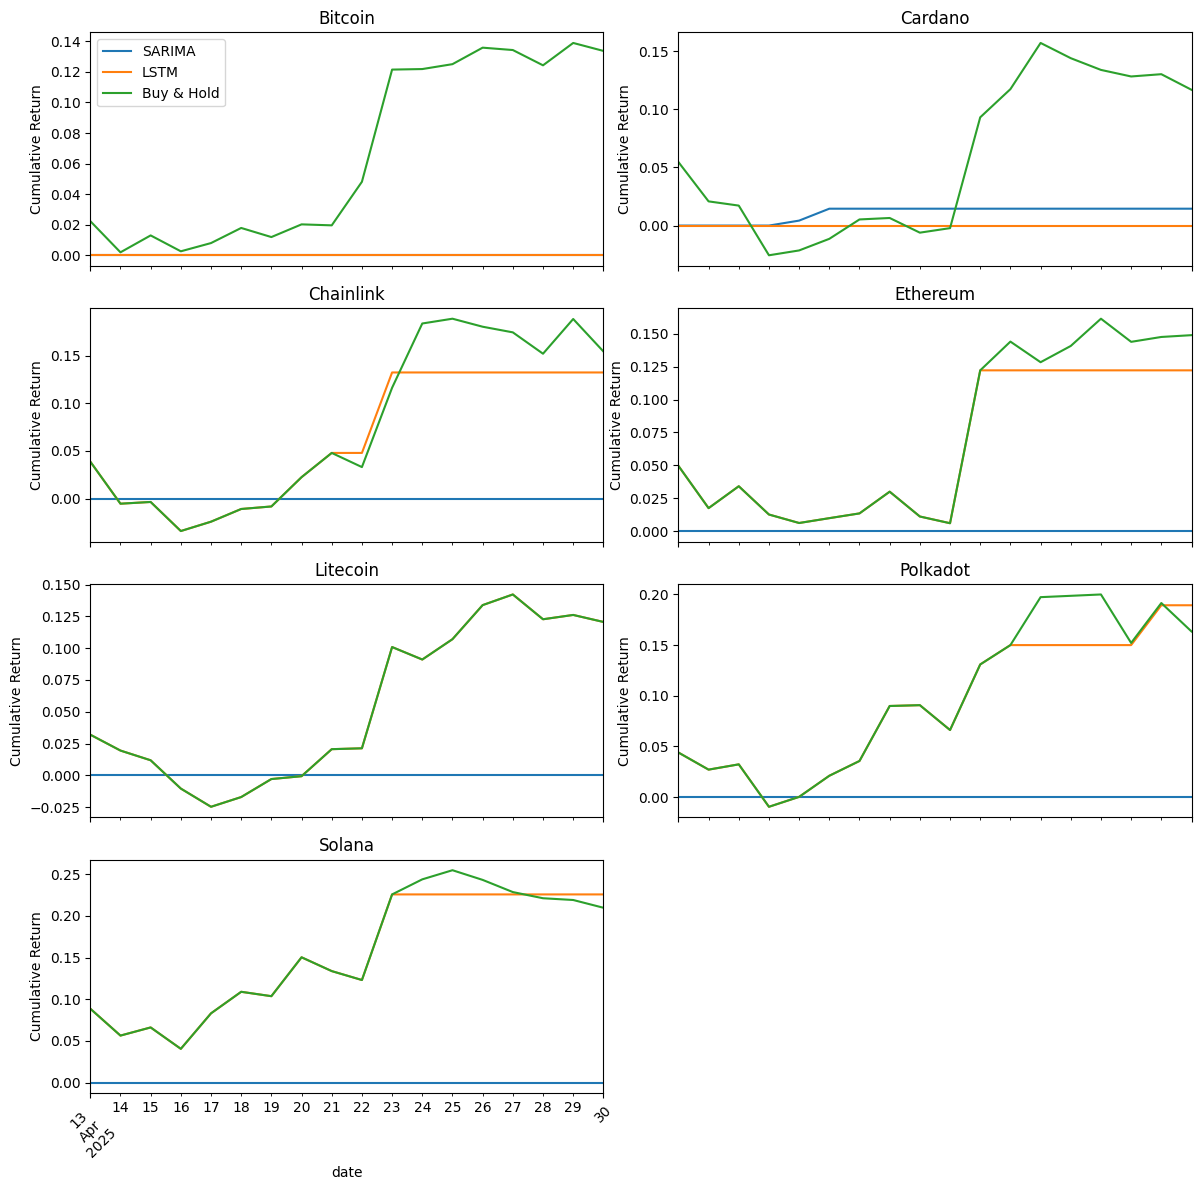

In [30]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

# ─── CONFIG ─────────────────────────────────────────────────────────────────────
MERGED_FP = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /merged_daily.csv"
WINDOW = 14
BATCH = 16
EPOCHS = 5
LR = 1e-3

# ─── Model for univariate LSTM ─────────────────────────────────────────────────
class UniLSTM(nn.Module):
    def __init__(self, hid=32):
        super().__init__()
        self.lstm = nn.LSTM(1, hid, batch_first=True)
        self.fc = nn.Linear(hid, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ─── Load and prepare data ─────────────────────────────────────────────────────
df = pd.read_csv(MERGED_FP, parse_dates=["date"])
df_unique = df.groupby(["date","crypto_name"], as_index=False)["price_usd"].mean()
pv = df_unique.pivot(index="date", columns="crypto_name", values="price_usd").asfreq("D").ffill()

# ─── Collect strategy returns per coin ─────────────────────────────────────────
strategy_cum = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for coin in pv.columns:
    series = pv[coin].dropna()
    cut = int(len(series) * 0.8)
    train, test = series.iloc[:cut], series.iloc[cut:]
    dates_test = test.index

    # SARIMA forecast
    sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7),
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    fcst_s = sarima.forecast(steps=len(test))
    fcst_s.index = dates_test

    # LSTM forecast
    # scale series
    scaler = MinMaxScaler()
    s_s = scaler.fit_transform(series.values.reshape(-1,1)).flatten()
    # build windows
    X, y = [], []
    for i in range(len(s_s) - WINDOW):
        X.append(s_s[i:i+WINDOW])
        y.append(s_s[i+WINDOW])
    X = np.array(X, dtype=np.float32)[:, :, None]
    y = np.array(y, dtype=np.float32)
    # split aligned
    X_tr, X_te = X[:cut-WINDOW], X[cut-WINDOW:]
    y_tr, y_te = y[:cut-WINDOW], y[cut-WINDOW:]
    # DataLoader
    dl_tr = DataLoader(TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)), batch_size=BATCH, shuffle=True)
    dl_te = DataLoader(TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te)), batch_size=BATCH)
    # train model
    model = UniLSTM().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    for _ in range(EPOCHS):
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            opt.zero_grad()
            l = loss_fn(model(xb), yb)
            l.backward(); opt.step()
    # predict
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in dl_te:
            out = model(xb.to(device)).cpu().numpy().flatten()
            preds.extend(out.tolist())
    preds = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
    fcst_l = pd.Series(preds, index=dates_test)

    # simulate strategies
    price_today = series.shift(1).reindex(dates_test).ffill()
    ret_act = series.pct_change().reindex(dates_test).fillna(0)
    sig_s = (fcst_s > price_today).astype(int)
    sig_l = (fcst_l > price_today).astype(int)
    strat_s = sig_s * ret_act
    strat_l = sig_l * ret_act
    strat_b = ret_act

    cum = pd.DataFrame({
        "SARIMA": (1+strat_s).cumprod()-1,
        "LSTM":   (1+strat_l).cumprod()-1,
        "Buy & Hold": (1+strat_b).cumprod()-1
    }, index=dates_test)

    strategy_cum[coin] = cum

# ─── Plot all coins ─────────────────────────────────────────────────────────────
import math
n = len(strategy_cum)
cols = 2
rows = math.ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(12, rows*3), sharex=True)
axes = axes.flatten()

for idx, (coin, cum_df) in enumerate(strategy_cum.items()):
    ax = axes[idx]
    cum_df.plot(ax=ax, title=coin, legend=(idx==0))
    ax.set_ylabel("Cumulative Return")
    ax.tick_params(axis='x', rotation=45)

for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [31]:
import pandas as pd
import numpy as np

# 1) Reconstruct your strategy_cum dict (or import it if you saved it)
#    If you ran the backtest script above, you could `import strategy_cum` from it.
#    For brevity, let’s re-run just the SARIMA & LSTM backtests for Bitcoin here;
#    you’d wrap that in a loop over all coins.

# … assume strategy_cum is a dict: { coin: DataFrame(index=dates, columns=[‘SARIMA’,’LSTM’,’Buy & Hold’]) }

# For demonstration let’s load it from a pickle (if you saved it):
# strategy_cum = pd.read_pickle('strategy_cum_all_coins.pkl')

# Or if you have it in memory, skip the load step.

metrics = []
for coin, cum_df in strategy_cum.items():
    for strat in cum_df.columns:
        # 1a) Final cumulative return
        final_ret = cum_df[strat].iloc[-1]
        # 1b) Daily returns of the strategy
        daily_ret = cum_df[strat].diff().fillna(cum_df[strat].iloc[0])
        # 1c) Sharpe ratio = mean(daily_ret) / std(daily_ret) * sqrt(252)
        sr = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252)
        # 1d) Max drawdown
        peak = cum_df[strat].cummax()
        dd   = (cum_df[strat] - peak) / peak
        mdd  = dd.min()
        metrics.append({
            'crypto_name': coin,
            'strategy':    strat,
            'final_return': final_ret,
            'sharpe':      sr,
            'max_drawdown': mdd
        })

# 2) Build DataFrame
metrics_df = pd.DataFrame(metrics)
# 3) Pivot for readability
pivot = metrics_df.pivot(index='crypto_name', columns='strategy', values=['final_return','sharpe','max_drawdown'])
print(pivot)

# 4) (Optional) save to CSV
pivot.to_csv("strategy_performance_summary.csv")


            final_return                         sharpe                      \
strategy      Buy & Hold      LSTM    SARIMA Buy & Hold      LSTM    SARIMA   
crypto_name                                                                   
Bitcoin         0.133711  0.000000  0.000000   5.788030       NaN       NaN   
Cardano         0.116835  0.000000  0.014523   3.207942       NaN  5.000217   
Chainlink       0.154318  0.132278  0.000000   3.996672  4.320123       NaN   
Ethereum        0.148919  0.122168  0.000000   3.942888  3.345240       NaN   
Litecoin        0.120581  0.120581  0.000000   4.442396  4.442396       NaN   
Polkadot        0.163459  0.189318  0.000000   4.402824  6.183072       NaN   
Solana          0.209823  0.225809  0.000000   4.946489  5.478467       NaN   

            max_drawdown                   
strategy      Buy & Hold      LSTM SARIMA  
crypto_name                                
Bitcoin        -0.913425       NaN    NaN  
Cardano        -1.467428       Na

/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/694625324.py:24: RuntimeWarning: invalid value encountered in scalar divide
  sr = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252)


In [32]:
import pandas as pd
import numpy as np

# suppose you already built this DataFrame:
#   metrics_df with columns [crypto_name, strategy, final_return, sharpe, max_drawdown]
# (from the code we ran earlier)

# 1) Pivot it wide
pivot = metrics_df.pivot_table(
    index='strategy',
    values=['final_return','sharpe','max_drawdown'],
    aggfunc='mean'
)

print("🏆 Average performance by strategy:\n", pivot)
pivot.to_csv("strategy_avg_performance.csv")


🏆 Average performance by strategy:
             final_return  max_drawdown    sharpe
strategy                                        
Buy & Hold      0.149664     -1.238328  4.389606
LSTM            0.112879     -1.257488  4.753860
SARIMA          0.002075      0.000000  5.000217


In [37]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ─── CONFIG ─────────────────────────────────────────────────────────────────────
MERGED_FP = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /merged_daily.csv"
OUT_FP    = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /live_recommendations.csv"
WINDOW    = 14
EPOCHS    = 5
BATCH     = 16
HIDDEN    = 32
LR        = 1e-3

# ─── 0) Device ──────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 1) Load & dedupe price series ──────────────────────────────────────────────
df = pd.read_csv(MERGED_FP, parse_dates=["date"])
df = (
    df
    .groupby(["date","crypto_name"], as_index=False)["price_usd"]
    .mean()
)

# ─── 2) LSTM model definition ───────────────────────────────────────────────────
class UniLSTM(nn.Module):
    def __init__(self, hidden_size=HIDDEN):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ─── 3) Forecast loop ──────────────────────────────────────────────────────────
signals = []
for coin in df.crypto_name.unique():
    # extract and resample
    series = (
        df[df.crypto_name==coin]
        .set_index("date")["price_usd"]
        .asfreq("D")
        .ffill()
    )
    if len(series) < WINDOW*2:
        continue  # skip if too little data

    p_today = float(series.iloc[-1])

    # ── SARIMA forecast ─────────────────────────────────────────────────
    sar = SARIMAX(
        series,
        order=(1,1,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    fc_s = float(sar.forecast(1).iloc[0])

    # ── PyTorch LSTM forecast ───────────────────────────────────────────
    vals = series.values.reshape(-1,1)
    scaler = MinMaxScaler().fit(vals)
    scaled = scaler.transform(vals).flatten()

    # build sliding windows
    X, y = [], []
    for i in range(len(scaled) - WINDOW):
        X.append(scaled[i:i+WINDOW])
        y.append(scaled[i+WINDOW])
    X = np.array(X, dtype=np.float32)[:, :, None]
    y = np.array(y, dtype=np.float32)

    # train on full data
    X_tr = torch.from_numpy(X).to(device)
    y_tr = torch.from_numpy(y).unsqueeze(1).to(device)

    ds = TensorDataset(X_tr, y_tr)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True)

    model = UniLSTM().to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    model.train()
    for _ in range(EPOCHS):
        for xb, yb in dl:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

    # forecast next step (ensure float32 dtype)
    model.eval()
    last_win = torch.from_numpy(scaled[-WINDOW:].astype(np.float32).reshape(1,WINDOW,1)).to(device)
    with torch.no_grad():
        pred_s = model(last_win).cpu().numpy().flatten()[0]
    fc_l = float(scaler.inverse_transform([[pred_s]])[0,0])

    # recommendation based on LSTM
    rec = "BUY" if fc_l > p_today else "HOLD"

    signals.append({
        "crypto_name":     coin,
        "price_today_usd": round(p_today,4),
        "sarima_forecast": round(fc_s,4),
        "lstm_forecast":   round(fc_l,4),
        "recommendation":  rec
    })

# ─── 4) Save & print ───────────────────────────────────────────────────────────
live_df = pd.DataFrame(signals).set_index("crypto_name")
live_df.to_csv(OUT_FP)
print("✅ Live recommendations saved to:", OUT_FP)
print(live_df)


✅ Live recommendations saved to: /Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /live_recommendations.csv
             price_today_usd  sarima_forecast  lstm_forecast recommendation
crypto_name                                                                
Bitcoin           94596.0503       95894.7110     82181.9775           HOLD
Cardano               0.6969           0.7117         0.6695           HOLD
Chainlink            14.6162          15.1492        13.8459           HOLD
Ethereum           1801.6559        1835.7259      1994.5744            BUY
Litecoin             85.3893          86.7372        92.6159            BUY
Polkadot              4.1371           4.2605         4.3260            BUY
Solana              146.8634         149.2967       105.9131           HOLD


/opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ─── CONFIG ─────────────────────────────────────────────────────────────────────
MERGED_FP = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /merged_daily.csv"
WINDOW    = 14    # LSTM window
HIDDEN    = 16
EPOCHS    = 3
BATCH     = 8
LR        = 1e-3
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── UNIVARIATE LSTM MODEL ──────────────────────────────────────────────────────
class UniLSTM(nn.Module):
    def __init__(self, hidden_size=HIDDEN):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out,_ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ─── TRAIN LSTM ON A SERIES ─────────────────────────────────────────────────────
def train_lstm(series, lookback):
    vals   = series.values[:lookback].reshape(-1,1)
    scaler = MinMaxScaler().fit(vals)
    scaled = scaler.transform(vals).flatten()
    X, y   = [], []
    for i in range(len(scaled)-WINDOW):
        X.append(scaled[i:i+WINDOW])
        y.append(scaled[i+WINDOW])
    X = np.array(X, dtype=np.float32)[:, :, None]
    y = np.array(y, dtype=np.float32)

    X_tr = torch.from_numpy(X).to(device)
    y_tr = torch.from_numpy(y).unsqueeze(1).to(device)
    ds   = TensorDataset(X_tr, y_tr)
    dl   = DataLoader(ds, batch_size=BATCH, shuffle=True)

    model = UniLSTM().to(device)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    model.train()
    for _ in range(EPOCHS):
        for xb, yb in dl:
            optim.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optim.step()
    return model, scaler

def forecast_lstm(model, scaler, last_window):
    x = torch.from_numpy(last_window.astype(np.float32).reshape(1,WINDOW,1)).to(device)
    model.eval()
    with torch.no_grad():
        out = model(x).cpu().numpy().flatten()[0]
    return float(scaler.inverse_transform([[out]])[0,0])

# ─── MAIN WALK‐FORWARD LOOP ─────────────────────────────────────────────────────
df = pd.read_csv(MERGED_FP, parse_dates=['date'])
df = df.groupby(['date','crypto_name'], as_index=False)['price_usd'].mean()

records = []
for coin in df.crypto_name.unique():
    ts = (df[df.crypto_name==coin]
          .set_index('date')['price_usd']
          .asfreq('D')
          .ffill())
    n = len(ts)
    # need at least WINDOW + 1 days to do one-step forecast
    if n < WINDOW + 1:
        print(f"⚠️ Not enough data for {coin} ({n} days), skipping.")
        continue

    # dynamic lookback: use all but one day
    lookback = n - 1
    print(f"⏩  {coin}: using {lookback} days for training, 1 day for testing")

    # train LSTM on lookback days
    lstm_model, lstm_scaler = train_lstm(ts, lookback)

    # prepare history and true price
    history    = ts.iloc[:lookback]
    true_price = float(ts.iloc[lookback])
    prev_price = float(ts.iloc[lookback-1])

    # SARIMA on full history
    sar = SARIMAX(
        history,
        order=(1,1,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred_s = float(sar.forecast(1)[0])

    # LSTM forecast on last WINDOW days
    scaled_all = lstm_scaler.transform(history.values.reshape(-1,1)).flatten()
    last_win   = scaled_all[-WINDOW:]
    pred_l     = forecast_lstm(lstm_model, lstm_scaler, last_win)

    # record both
    for strat, pred in [('SARIMA', pred_s), ('LSTM', pred_l)]:
        records.append({
            'crypto':        coin,
            'strategy':      strat,
            'predicted':     pred,
            'actual':        true_price,
            'error_sq':      (pred - true_price)**2,
            'error_abs_pct': abs((pred - true_price) / true_price),
            'dir_correct':   int((pred > prev_price) == (true_price > prev_price))
        })

# ─── AGGREGATE & REPORT ───────────────────────────────────────────────────────
r = pd.DataFrame(records)
if r.empty:
    raise RuntimeError("No records collected—check your data length.")

print("Columns in result:", r.columns.tolist())
print("First few rows:\n", r.head(), "\n")

summary = (
    r
    .groupby('strategy')
    .agg(
        RMSE    = ('error_sq', lambda x: np.sqrt(x.mean())),
        MAPE    = ('error_abs_pct', 'mean'),
        DirAcc  = ('dir_correct', 'mean')
    )
    .round(4)
)

print("\n📊 One-day-ahead walk-forward performance:")
print(summary)


⏩  Bitcoin: using 89 days for training, 1 day for testing
⏩  Cardano: using 89 days for training, 1 day for testing
⏩  Chainlink: using 89 days for training, 1 day for testing


/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/188297199.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/188297199.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/188297199.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

⏩  Ethereum: using 89 days for training, 1 day for testing
⏩  Litecoin: using 89 days for training, 1 day for testing
⏩  Polkadot: using 89 days for training, 1 day for testing


/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/188297199.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/188297199.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])


⏩  Solana: using 89 days for training, 1 day for testing
Columns in result: ['crypto', 'strategy', 'predicted', 'actual', 'error_sq', 'error_abs_pct', 'dir_correct']
First few rows:
       crypto strategy     predicted        actual      error_sq  \
0    Bitcoin   SARIMA  97904.218338  94596.050262  1.094398e+07   
1    Bitcoin     LSTM  83474.501279  94596.050262  1.236889e+08   
2    Cardano   SARIMA      0.701543      0.696920  2.137148e-05   
3    Cardano     LSTM      0.623110      0.696920  5.448036e-03   
4  Chainlink   SARIMA     14.900673     14.616189  8.093139e-02   

   error_abs_pct  dir_correct  
0       0.034972            0  
1       0.117569            1  
2       0.006633            1  
3       0.105910            1  
4       0.019464            1   


📊 One-day-ahead walk-forward performance:
               RMSE    MAPE  DirAcc
strategy                           
LSTM      4203.5508  0.0785  1.0000
SARIMA    1250.3723  0.0150  0.5714


/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/188297199.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/188297199.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])


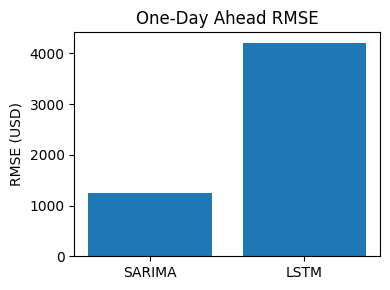

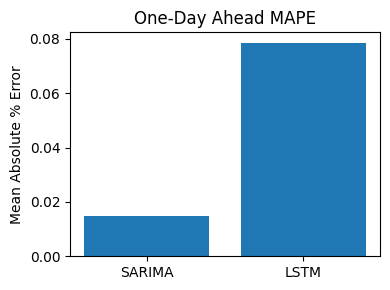

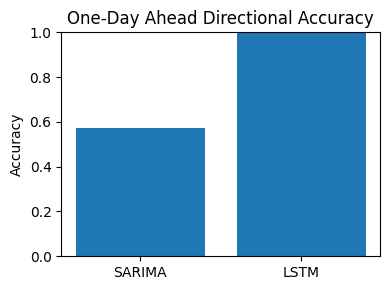

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Summary metrics from the walk-forward test
df = pd.DataFrame({
    'strategy': ['SARIMA', 'LSTM'],
    'RMSE':      [1250.3723, 4203.5508],
    'MAPE':      [0.0150,    0.0785],
    'DirAcc':    [0.5714,    1.0000]
}).set_index('strategy')

# Plot RMSE comparison
plt.figure(figsize=(4,3))
plt.bar(df.index, df['RMSE'])
plt.title("One-Day Ahead RMSE")
plt.ylabel("RMSE (USD)")
plt.tight_layout()
plt.show()

# Plot MAPE comparison
plt.figure(figsize=(4,3))
plt.bar(df.index, df['MAPE'])
plt.title("One-Day Ahead MAPE")
plt.ylabel("Mean Absolute % Error")
plt.tight_layout()
plt.show()

# Plot Directional Accuracy comparison
plt.figure(figsize=(4,3))
plt.bar(df.index, df['DirAcc'])
plt.title("One-Day Ahead Directional Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [48]:
#!/usr/bin/env python3
import argparse
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pathlib import Path

# ─── AUTO-DETECT merged_daily.csv ──────────────────────────────────────────────
root = (
    Path.home()
    / "ImpData"
    / "Crypto Sentiment Prediction"
    / "crypto_sentiment_project"
    / "data"
)
news_folder = next(
    d for d in root.iterdir()
    if d.is_dir() and d.name.startswith("News Data Crypto")
)
default_merged = news_folder / "merged_daily.csv"

# ─── MODEL / TRAIN / FORECAST ───────────────────────────────────────────────────
class UniLSTM(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def train_lstm(series, lookback, window, epochs, lr, batch, device):
    vals   = series.values[:lookback].reshape(-1,1)
    scaler = MinMaxScaler().fit(vals)
    scaled = scaler.transform(vals).flatten()
    X, y   = [], []
    for i in range(len(scaled)-window):
        X.append(scaled[i:i+window])
        y.append(scaled[i+window])
    X = np.array(X, dtype=np.float32)[:, :, None]
    y = np.array(y, dtype=np.float32)
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y).unsqueeze(1))
    dl = DataLoader(ds, batch_size=batch, shuffle=True)
    model = UniLSTM().to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.train()
    for _ in range(epochs):
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss_fn(model(xb), yb).backward()
            opt.step()
    return model, scaler

def forecast_lstm(model, scaler, last_window, window, device):
    import numpy as np, torch
    x = torch.from_numpy(last_window.astype(np.float32).reshape(1,window,1)).to(device)
    model.eval()
    with torch.no_grad():
        out = model(x).cpu().numpy().flatten()[0]
    return float(scaler.inverse_transform([[out]])[0,0])

# ─── WALK-FORWARD FUNCTION ─────────────────────────────────────────────────────
def run_walk_forward(merged_csv, window, epochs, lr, batch, device):
    df = pd.read_csv(merged_csv, parse_dates=["date"])
    df = df.groupby(["date","crypto_name"], as_index=False)["price_usd"].mean()

    records = []
    for coin in df.crypto_name.unique():
        ts = (df[df.crypto_name==coin]
              .set_index("date")["price_usd"]
              .asfreq("D").ffill())
        n = len(ts)
        if n < window+2:
            print(f"⚠️  Skipping {coin}: only {n} days")
            continue

        lookback = n - 1
        train_ts = ts.iloc[:lookback]
        true     = float(ts.iloc[lookback])
        prev     = float(ts.iloc[lookback-1])

        # SARIMA
        sar = SARIMAX(
            train_ts,
            order=(1,1,1),
            seasonal_order=(1,1,1,7),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        pred_s = float(sar.forecast(1)[0])

        # LSTM
        lstm_model, lstm_scaler = train_lstm(
            ts, lookback,
            window=window,
            epochs=epochs,
            lr=lr,
            batch=batch,
            device=device
        )
        scaled = lstm_scaler.transform(train_ts.values.reshape(-1,1)).flatten()
        last_w = scaled[-window:]
        pred_l = forecast_lstm(lstm_model, lstm_scaler, last_w, window, device)

        for strat, pred in [("SARIMA",pred_s), ("LSTM",pred_l)]:
            records.append({
                "strategy": strat,
                "error_sq": (pred-true)**2,
                "error_abs_pct": abs((pred-true)/true),
                "dir_correct": int((pred>prev)==(true>prev))
            })

    dfr = pd.DataFrame(records)
    summary = dfr.groupby("strategy").agg(
        RMSE   = ("error_sq", lambda x: np.sqrt(x.mean())),
        MAPE   = ("error_abs_pct", "mean"),
        DirAcc = ("dir_correct", "mean")
    ).round(4)

    summary.to_csv("walk_forward_summary.csv")
    print("✅ Written walk_forward_summary.csv")
    print(summary)

# ─── ARGPARSE & ENTRYPOINT ──────────────────────────────────────────────────────
if __name__=="__main__":
    p = argparse.ArgumentParser()
    p.add_argument(
        "--merged-csv",
        default=str(default_merged),
        help=f"path to merged_daily.csv (default: {default_merged})"
    )
    p.add_argument("--window", type=int, default=14)
    p.add_argument("--epochs", type=int, default=3)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--batch", type=int, default=8)
    p.add_argument("--device", default="cpu")

    # <—- changed here:
    args, _ = p.parse_known_args()

    run_walk_forward(
        args.merged_csv,
        args.window,
        args.epochs,
        args.lr,
        args.batch,
        args.device
    )


/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/2689093906.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/2689093906.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/2689093906.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

✅ Written walk_forward_summary.csv
               RMSE    MAPE  DirAcc
strategy                           
LSTM      5528.9813  0.1046  0.8571
SARIMA    1250.3723  0.0150  0.5714


/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/2689093906.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])
/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_87920/2689093906.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_s = float(sar.forecast(1)[0])


In [55]:
#!/usr/bin/env python3
import argparse
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader

# ─── SILENCE WARNINGS ────────────────────────────────────────────────────────────
warnings.filterwarnings("ignore", category=UserWarning)      # SARIMAX warnings
warnings.filterwarnings("ignore", category=FutureWarning)    # pandas futurewarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)   # any runtime warnings

# ─── AUTO-DETECT data paths ─────────────────────────────────────────────────────
root = (
    Path.home()
    / "ImpData"
    / "Crypto Sentiment Prediction"
    / "crypto_sentiment_project"
    / "data"
)
news_folder = next(
    d for d in root.iterdir()
    if d.is_dir() and d.name.startswith("News Data Crypto")
)
MERGED_CSV = news_folder / "merged_daily.csv"
OUT_FOLDER = news_folder / "backtests"
OUT_FOLDER.mkdir(exist_ok=True)

# ─── LSTM MODEL ─────────────────────────────────────────────────────────────────
class UniLSTM(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def train_lstm(series, lookback, window, epochs, lr, batch, device):
    vals   = series.values[:lookback].reshape(-1,1)
    scaler = MinMaxScaler().fit(vals)
    scaled = scaler.transform(vals).flatten()

    X, y = [], []
    for i in range(len(scaled) - window):
        X.append(scaled[i:i+window])
        y.append(scaled[i+window])

    X = np.array(X, dtype=np.float32)[:, :, None]
    y = np.array(y, dtype=np.float32)

    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y).unsqueeze(1))
    dl = DataLoader(ds, batch_size=batch, shuffle=True)

    model = UniLSTM().to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss_fn(model(xb), yb).backward()
            opt.step()

    return model, scaler

def forecast_lstm(model, scaler, last_window, device):
    x = torch.from_numpy(last_window.astype(np.float32).reshape(1, -1, 1)).to(device)
    model.eval()
    with torch.no_grad():
        out = model(x).cpu().numpy().flatten()[0]
    return float(scaler.inverse_transform([[out]])[0,0])

# ─── BACKTEST ONE COIN ───────────────────────────────────────────────────────────
def backtest_coin(df_coin, out_folder, window, device):
    # 1) aggregate duplicates, resample daily
    prices = (
        df_coin.set_index("date")["price_usd"]
        .groupby(level=0).mean()
        .asfreq("D").ffill()
    )
    n = len(prices)
    if n < window + 2:
        print(f"⚠️ {df_coin.crypto_name.iloc[0]} needs ≥{window+2} days, got {n}, skipping.")
        return

    lookback = window + 1
    # 2) train LSTM on first window+1 days
    lstm_model, lstm_scaler = train_lstm(
        prices, lookback,
        window=window,
        epochs=3,
        lr=1e-3,
        batch=16,
        device=device
    )

    eq_sar = []
    eq_lst = []
    eq_bh  = []

    # 3) walk forward from t=lookback to n-1
    for t in range(lookback, n):
        prev_price = prices.iloc[t-1]
        curr_price = prices.iloc[t]

        # SARIMA forecast
        sar = SARIMAX(
            prices.iloc[:t],
            order=(1,1,1),
            seasonal_order=(1,1,1,7),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        pred_s = float(sar.forecast(1)[0])

        # LSTM forecast
        scaled_all = lstm_scaler.transform(prices.iloc[:t].values.reshape(-1,1)).flatten()
        last_win   = scaled_all[-window:]
        pred_l     = forecast_lstm(lstm_model, lstm_scaler, last_win, device)

        # signals & returns
        signal_s = 1 if pred_s > prev_price else 0
        signal_l = 1 if pred_l > prev_price else 0
        ret_s = (curr_price/prev_price)*signal_s + (1-signal_s)
        ret_l = (curr_price/prev_price)*signal_l + (1-signal_l)
        ret_bh = curr_price/prev_price
        eq_sar.append(ret_s if not eq_sar else eq_sar[-1]*ret_s)
        eq_lst.append(ret_l if not eq_lst else eq_lst[-1]*ret_l)
        eq_bh.append(ret_bh if not eq_bh else eq_bh[-1]*ret_bh)

    # 4) save
    dates = prices.index[lookback:]
    out_df = pd.DataFrame({
        "date": dates,
        "SARIMA": eq_sar,
        "LSTM":   eq_lst,
        "Buy & Hold": eq_bh
    }).set_index("date")

    coin = df_coin.crypto_name.iloc[0].replace(" ", "_")
    fp = out_folder / f"{coin}_cum_returns.csv"
    out_df.to_csv(fp)
    print(f"✅ {coin} → {fp.name}")

# ─── MAIN ───────────────────────────────────────────────────────────────────────
def main():
    p = argparse.ArgumentParser()
    p.add_argument("--merged-csv", default=str(MERGED_CSV))
    p.add_argument("--out-folder", default=str(OUT_FOLDER))
    p.add_argument("--window", type=int, default=14)
    p.add_argument("--device", default="cpu")
    args, _ = p.parse_known_args()

    df = pd.read_csv(args.merged_csv, parse_dates=["date"])
    out_folder = Path(args.out_folder)
    out_folder.mkdir(exist_ok=True)

    for coin in df.crypto_name.unique():
        backtest_coin(df[df.crypto_name==coin], out_folder, args.window, args.device)

if __name__=="__main__":
    main()


✅ Bitcoin → Bitcoin_cum_returns.csv
✅ Cardano → Cardano_cum_returns.csv
✅ Chainlink → Chainlink_cum_returns.csv
✅ Ethereum → Ethereum_cum_returns.csv
✅ Litecoin → Litecoin_cum_returns.csv
✅ Polkadot → Polkadot_cum_returns.csv
✅ Solana → Solana_cum_returns.csv


In [56]:
pip install plotly


  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
Using cached plotly-6.0.1-py3-none-any.whl (14.8 MB)

[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [58]:
pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
pip install vaderSentiment


[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [65]:
#!/usr/bin/env python3
import pandas as pd
from transformers import pipeline
from tqdm.auto import tqdm

# ─── 0) Point these at your actual files ────────────────────────────────────────
REDDIT_CSV       = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /reddit_crypto_2000_posts.csv"
COINTELE_XLSX    = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /cointelegraph_bitcoin_scroll_fixed.xlsx"
CRYPTOSLATE_XLSX = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /cryptoslate_articles_wpapi.xlsx"
PRICES_CSV       = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /historical_prices.csv"
OUT_MERGED_CSV   = "/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /merged_daily.csv"

# ─── 1) load all three sources ─────────────────────────────────────────────────
reddit     = pd.read_csv(REDDIT_CSV,      parse_dates=["created_utc"])
cointele   = pd.read_excel(COINTELE_XLSX, parse_dates=["scraped_at"])
cryptoslate= pd.read_excel(CRYPTOSLATE_XLSX, parse_dates=["date"])

# unify date & rename
reddit["date"]       = reddit.created_utc.dt.date
cointele["date"]     = cointele.scraped_at.dt.date
cryptoslate["date"]  = cryptoslate.date.dt.date

for df in (reddit, cointele, cryptoslate):
    df.rename(columns={
        "detected_coins":"crypto_name",
        "title":"headline"
    }, inplace=True)

all_news = pd.concat([
    reddit[["crypto_name","date","headline"]],
    cointele[["crypto_name","date","headline"]],
    cryptoslate[["crypto_name","date","headline"]]
], ignore_index=True)

# ─── 2) sentiment-analysis pipeline ─────────────────────────────────────────────
print("🧠 loading HuggingFace sentiment-analysis pipeline…")
sa = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

print("📝 running sentiment analysis on headlines…")
results = []
for i in tqdm(range(0, len(all_news), 32)):
    batch = all_news.headline.iloc[i:i+32].tolist()
    results.extend(sa(batch, truncation=True))

sent_df = pd.DataFrame(results)
all_news["sent_label"] = sent_df.label.str.lower()  # positive/negative
all_news["sent_score"] = sent_df.score

all_news["compound"] = all_news.apply(
    lambda r:  r.sent_score if r.sent_label=="positive" else -r.sent_score,
    axis=1
)

# ─── 3) aggregate per (coin, date) ─────────────────────────────────────────────
agg = ( all_news
    .groupby(["crypto_name","date"])
    .agg(
        news_count   = ("headline","size"),
        pct_positive = ("sent_label", lambda s: (s=="positive").mean()),
        pct_negative = ("sent_label", lambda s: (s=="negative").mean()),
        avg_compound = ("compound","mean")
    )
    .reset_index()
)

# ─── 4) merge with your prices ─────────────────────────────────────────────────
prices = pd.read_csv(PRICES_CSV, parse_dates=["date"])
prices["date"] = prices.date.dt.date

merged = ( prices
    .merge(agg, on=["crypto_name","date"], how="left")
    .fillna({"news_count":0, "pct_positive":0, "pct_negative":0, "avg_compound":0})
)

# ─── 5) save your merged table ────────────────────────────────────────────────
merged.to_csv(OUT_MERGED_CSV, index=False)
print(f"✅ built `{OUT_MERGED_CSV}` with {len(merged)} rows.")


🧠 loading HuggingFace sentiment-analysis pipeline…


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
2025-04-30 12:21:26,155 WARNING Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use mps:0


📝 running sentiment analysis on headlines…


100%|███████████████████████████████████████████| 73/73 [00:17<00:00,  4.11it/s]

✅ built `/Users/jinenmodi/ImpData/Crypto Sentiment Prediction/crypto_sentiment_project/data/News Data Crypto /merged_daily.csv` with 637 rows.


In [12]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# ──────────────────────────────── patch at top ────────────────────────────────
# silence SARIMAX convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)

# ────────────────────────────── run_walk_forward ──────────────────────────────
def run_walk_forward(merged_csv, window, epochs, lr, batch, device):
    df = pd.read_csv(merged_csv, parse_dates=["date"])
    coins = df.crypto_name.unique()
    records = []

    for coin in coins:
        ts = (
            df[df.crypto_name == coin]
              .groupby("date")["price_usd"]
              .mean()
              .asfreq("D")
              .ffill()
        )

        for lookback in range(window, len(ts) - 1):
            train_ts = ts.iloc[:lookback]
            true      = float(ts.iloc[lookback])
            prev      = float(ts.iloc[lookback - 1])

            # ── SARIMA (with maxiter) ─────────────────────────────────────────
            try:
                sar_model = SARIMAX(
                    train_ts,
                    order=(1,1,1),
                    seasonal_order=(1,1,1,7),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                # limit iterations to speed up
                sar = sar_model.fit(disp=False, maxiter=10)
                pred_s = float(sar.forecast(1).iloc[0])
            except Exception:
                # fallback to "no change"
                pred_s = prev

            # ── LSTM ─────────────────────────────────────────────────────────────
            lstm_model, lstm_scaler = train_lstm(train_ts, window, epochs, lr, batch, device)
            if lstm_model is None:
                pred_l = prev
            else:
                scaled = lstm_scaler.transform(train_ts.values.reshape(-1,1)).flatten()
                last_win = scaled[-window:]
                pred_l = forecast_lstm(lstm_model, lstm_scaler, last_win, device)

            for strat, pred in [("SARIMA", pred_s), ("LSTM", pred_l)]:
                records.append({
                    "strategy":      strat,
                    "error_sq":      (pred - true)**2,
                    "error_abs_pct": abs((pred - true)/true),
                    "dir_correct":   int((pred > prev) == (true > prev))
                })

    summary = (
        pd.DataFrame(records)
          .groupby("strategy")
          .agg(
            RMSE   = ("error_sq", lambda x: np.sqrt(x.mean())),
            MAPE   = ("error_abs_pct", "mean"),
            DirAcc = ("dir_correct", "mean")
          )
          .round(4)
    )
    summary.to_csv("walk_forward_summary.csv", index=True)
    print("✅ Written walk_forward_summary.csv")
    print(summary)


/var/folders/14/lwdqxjmj54dcx0n3tktty0gw0000gn/T/ipykernel_28583/3082093894.py:68: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


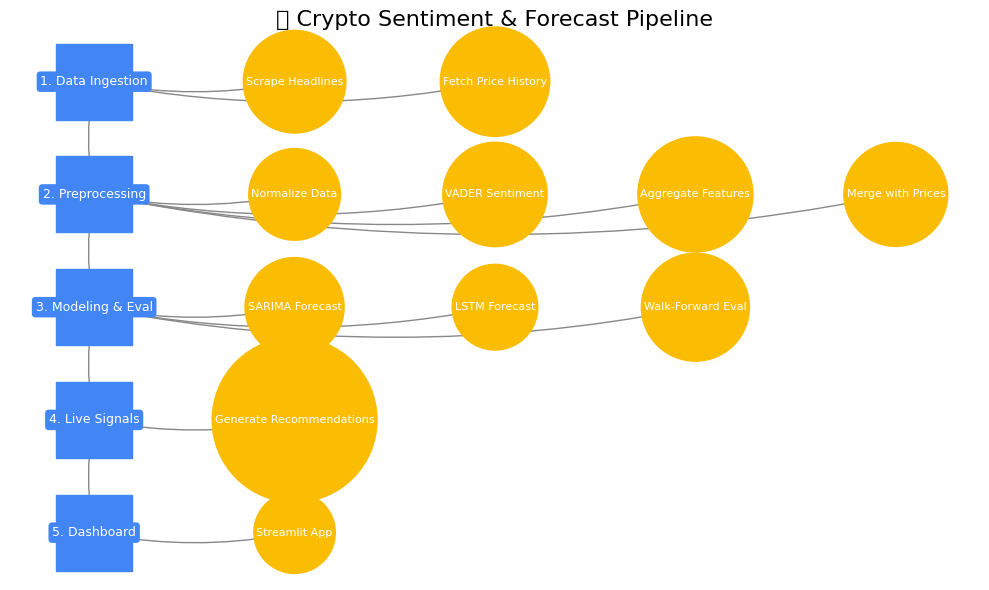

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

# Define your stages and subtasks
stages = [
    ("1. Data Ingestion",      ["Scrape Headlines", "Fetch Price History"]),
    ("2. Preprocessing",       ["Normalize Data", "VADER Sentiment", "Aggregate Features", "Merge with Prices"]),
    ("3. Modeling & Eval",     ["SARIMA Forecast", "LSTM Forecast", "Walk-Forward Eval"]),
    ("4. Live Signals",        ["Generate Recommendations"]),
    ("5. Dashboard",           ["Streamlit App"])
]

# Build the graph and set positions
G = nx.DiGraph()
pos = {}
for i, (stage, subtasks) in enumerate(stages):
    y = -i * 2
    pos[stage] = (0, y)
    G.add_node(stage)
    for j, sub in enumerate(subtasks):
        pos[sub] = (j + 1, y)
        G.add_node(sub)
        G.add_edge(stage, sub)
    if i > 0:
        G.add_edge(stages[i-1][0], stage)

# Plot
plt.figure(figsize=(10, 6))
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>', arrowsize=12,
    edge_color='#888888',
    connectionstyle='arc3,rad=0.1'
)
# Stage nodes (squares)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=[s for s, _ in stages],
    node_shape='s', node_color='#4285F4', node_size=3000
)
# Subtask nodes (circles)
subnodes = [sub for _, lst in stages for sub in lst]
nx.draw_networkx_nodes(
    G, pos,
    nodelist=subnodes,
    node_shape='o', node_color='#FBBC04', node_size=2000
)

# Custom labels with bounding boxes
for node, (x, y) in pos.items():
    is_stage = node in [s for s, _ in stages]
    bbox_props = dict(
        boxstyle="round,pad=0.3" if is_stage else "circle,pad=0.3",
        fc="#4285F4" if is_stage else "#FBBC04",
        ec="none"
    )
    plt.text(
        x, y,
        node,
        fontsize=9 if is_stage else 8,
        ha="center", va="center",
        color="white",
        bbox=bbox_props
    )

plt.axis('off')
plt.title("🚀 Crypto Sentiment & Forecast Pipeline", fontsize=16)
plt.tight_layout()
plt.show()
